# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [60]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets, on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### Set up

In [61]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
from datetime import datetime
import pathlib

np.random.seed(22)#813306)

      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  
nb_epochs = 5000

### User inputs

In [62]:
# Directories
fdir = '../data'  
logs_dir = '../logs'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp
seed = 35 # seed for initialising random weights in the NN.
flist = ['GunPoint']
#flist = ['Adiac', 'Beef', 'CBF', 'ChlorineConcentration', 'CinC_ECG_torso', 'Coffee', 'Cricket_X', 'Cricket_Y', 'Cricket_Z', 
#'DiatomSizeReduction', 'ECGFiveDays', 'FaceAll', 'FaceFour', 'FacesUCR', '50words', 'FISH', 'GunPoint', 'Haptics', 
#'InlineSkate', 'ItalyPowerDemand', 'Lighting2', 'Lighting7', 'MALLAT', 'MedicalImages', 'MoteStrain', 'NonInvasiveFatalECG_Thorax1', 
#'NonInvasiveFatalECG_Thorax2', 'OliveOil', 'OSULeaf', 'SonyAIBORobotSurface', 'SonyAIBORobotSurfaceII', 'StarLightCurves', 'SwedishLeaf', 'Symbols', 
#'synthetic_control', 'Trace', 'TwoLeadECG', 'Two_Patterns', 'uWaveGestureLibrary_X', 'uWaveGestureLibrary_Y', 'uWaveGestureLibrary_Z', 'wafer', 'WordsSynonyms', 'yoga']



### Visualise the data

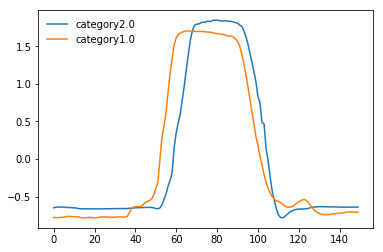

In [63]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Train the MLP

In [64]:
for each in flist:
    fname = each
    print('Running dataset', fname)
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    batch_size = int(min(x_train.shape[0]/10, 16))
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
     
   # x_test_min = np.min(x_test, axis = 1, keepdims=1)
   # x_test_max = np.max(x_test, axis = 1, keepdims=1)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    #x_train = x_train.reshape(x_train.shape + (1,))
    #x_test = x_test.reshape(x_test.shape + (1,))
    
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
     
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=1, validation_data=(x_test, Y_test), 
                #callbacks = [TestCallback((x_train, Y_train)), reduce_lr, keras.callbacks.TensorBoard(log_dir='./log'+fname, histogram_freq=1)])
                 callbacks=[reduce_lr])
    end = time.time()
    
    log = pd.DataFrame(hist.history)
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    print('Training time ', end-start, 'seconds, which is about', round((end-start)/60), 'minutes.')
    print('Selected the test result with the lowest training loss. Loss and accuracy are -')
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc)
    print('For the results table -')
    print('|#   |',loss,'  |',val_acc,' |', timestamp, '  |')
    # Save log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    print('Saving logs to',logs_dir+'/'+fname+'/history.csv')
    log.to_csv(logs_dir+'/'+fname+'/history.csv')
 



Running dataset GunPoint
Train on 50 samples, validate on 150 samples
Epoch 1/5000
50/50 [==============================] - 1s 15ms/step - loss: 0.6883 - acc: 0.5800 - val_loss: 0.6745 - val_acc: 0.4933
Epoch 2/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.6057 - acc: 0.6400 - val_loss: 0.5387 - val_acc: 0.7133
Epoch 3/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.4519 - acc: 0.8000 - val_loss: 0.4298 - val_acc: 0.8067
Epoch 4/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.3197 - acc: 0.8200 - val_loss: 0.4178 - val_acc: 0.7800
Epoch 5/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2725 - acc: 0.9000 - val_loss: 0.6979 - val_acc: 0.6667
Epoch 6/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.3370 - acc: 0.8600 - val_loss: 0.4427 - val_acc: 0.7733
Epoch 7/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2229 - acc: 0.8800 - val_loss: 0.4222 - val_acc: 0.7600
Epoch

50/50 [==============================] - 0s 3ms/step - loss: 0.0214 - acc: 1.0000 - val_loss: 0.1707 - val_acc: 0.9333
Epoch 63/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.2830 - val_acc: 0.9267
Epoch 64/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.2282 - val_acc: 0.9400
Epoch 65/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0485 - acc: 0.9800 - val_loss: 0.4009 - val_acc: 0.8800
Epoch 66/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0968 - acc: 0.9600 - val_loss: 0.5969 - val_acc: 0.8200
Epoch 67/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0224 - acc: 1.0000 - val_loss: 0.1926 - val_acc: 0.9400
Epoch 68/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1008 - acc: 0.9600 - val_loss: 0.2369 - val_acc: 0.9200
Epoch 69/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0089 -

50/50 [==============================] - 0s 3ms/step - loss: 6.0775e-04 - acc: 1.0000 - val_loss: 0.3194 - val_acc: 0.9467
Epoch 124/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.6461e-05 - acc: 1.0000 - val_loss: 0.3266 - val_acc: 0.9467
Epoch 125/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3029e-04 - acc: 1.0000 - val_loss: 0.3306 - val_acc: 0.9467
Epoch 126/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.3078e-05 - acc: 1.0000 - val_loss: 0.3325 - val_acc: 0.9467
Epoch 127/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0668e-04 - acc: 1.0000 - val_loss: 0.3338 - val_acc: 0.9467
Epoch 128/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.0597e-04 - acc: 1.0000 - val_loss: 0.3342 - val_acc: 0.9467
Epoch 129/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5110e-04 - acc: 1.0000 - val_loss: 0.3355 - val_acc: 0.9467
Epoch 130/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 9.1168e-06 - acc: 1.0000 - val_loss: 0.4277 - val_acc: 0.9333
Epoch 183/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1241e-05 - acc: 1.0000 - val_loss: 0.4287 - val_acc: 0.9333
Epoch 184/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.6097e-05 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.9333
Epoch 185/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.8946e-05 - acc: 1.0000 - val_loss: 0.4316 - val_acc: 0.9333
Epoch 186/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7103e-05 - acc: 1.0000 - val_loss: 0.4336 - val_acc: 0.9333
Epoch 187/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1109e-04 - acc: 1.0000 - val_loss: 0.4437 - val_acc: 0.9333
Epoch 188/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2688e-05 - acc: 1.0000 - val_loss: 0.4575 - val_acc: 0.9333
Epoch 189/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 5.2767e-06 - acc: 1.0000 - val_loss: 0.4957 - val_acc: 0.9267
Epoch 242/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6505e-06 - acc: 1.0000 - val_loss: 0.4956 - val_acc: 0.9267
Epoch 243/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.0841e-05 - acc: 1.0000 - val_loss: 0.4970 - val_acc: 0.9267
Epoch 244/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.6880e-06 - acc: 1.0000 - val_loss: 0.4983 - val_acc: 0.9267
Epoch 245/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.0746e-06 - acc: 1.0000 - val_loss: 0.4989 - val_acc: 0.9267
Epoch 246/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3387e-06 - acc: 1.0000 - val_loss: 0.4988 - val_acc: 0.9267
Epoch 247/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0067e-05 - acc: 1.0000 - val_loss: 0.4986 - val_acc: 0.9267
Epoch 248/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 7.3175e-06 - acc: 1.0000 - val_loss: 0.5304 - val_acc: 0.9200
Epoch 301/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.2097e-06 - acc: 1.0000 - val_loss: 0.5289 - val_acc: 0.9200
Epoch 302/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8876e-07 - acc: 1.0000 - val_loss: 0.5281 - val_acc: 0.9200
Epoch 303/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.7025e-06 - acc: 1.0000 - val_loss: 0.5277 - val_acc: 0.9200
Epoch 304/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.9360e-06 - acc: 1.0000 - val_loss: 0.5275 - val_acc: 0.9200
Epoch 305/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1948e-07 - acc: 1.0000 - val_loss: 0.5275 - val_acc: 0.9200
Epoch 306/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1637e-05 - acc: 1.0000 - val_loss: 0.5251 - val_acc: 0.9200
Epoch 307/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 7.5460e-07 - acc: 1.0000 - val_loss: 0.5226 - val_acc: 0.9400
Epoch 360/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0228e-06 - acc: 1.0000 - val_loss: 0.5228 - val_acc: 0.9400
Epoch 361/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1160e-06 - acc: 1.0000 - val_loss: 0.5230 - val_acc: 0.9400
Epoch 362/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.9648e-06 - acc: 1.0000 - val_loss: 0.5235 - val_acc: 0.9400
Epoch 363/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.9513e-07 - acc: 1.0000 - val_loss: 0.5239 - val_acc: 0.9400
Epoch 364/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.3672e-07 - acc: 1.0000 - val_loss: 0.5241 - val_acc: 0.9400
Epoch 365/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2279e-06 - acc: 1.0000 - val_loss: 0.5243 - val_acc: 0.9400
Epoch 366/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 6.1099e-06 - acc: 1.0000 - val_loss: 0.5551 - val_acc: 0.9400
Epoch 419/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6373e-07 - acc: 1.0000 - val_loss: 0.5559 - val_acc: 0.9400
Epoch 420/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5104e-05 - acc: 1.0000 - val_loss: 0.5581 - val_acc: 0.9400
Epoch 421/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.6320e-06 - acc: 1.0000 - val_loss: 0.5592 - val_acc: 0.9400
Epoch 422/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0610e-06 - acc: 1.0000 - val_loss: 0.5599 - val_acc: 0.9400
Epoch 423/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8931e-06 - acc: 1.0000 - val_loss: 0.5602 - val_acc: 0.9400
Epoch 424/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.7432e-07 - acc: 1.0000 - val_loss: 0.5606 - val_acc: 0.9400
Epoch 425/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 2.8014e-07 - acc: 1.0000 - val_loss: 0.5773 - val_acc: 0.9467
Epoch 478/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.4359e-06 - acc: 1.0000 - val_loss: 0.5807 - val_acc: 0.9467
Epoch 479/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.4997e-07 - acc: 1.0000 - val_loss: 0.5826 - val_acc: 0.9467
Epoch 480/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.0320e-07 - acc: 1.0000 - val_loss: 0.5839 - val_acc: 0.9467
Epoch 481/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.4782e-07 - acc: 1.0000 - val_loss: 0.5846 - val_acc: 0.9467
Epoch 482/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.5685e-07 - acc: 1.0000 - val_loss: 0.5848 - val_acc: 0.9467
Epoch 483/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.5671e-07 - acc: 1.0000 - val_loss: 0.5850 - val_acc: 0.9467
Epoch 484/5000
50/50 [===========================

Epoch 537/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0955 - acc: 0.9600 - val_loss: 0.3246 - val_acc: 0.9000
Epoch 538/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0537 - acc: 0.9800 - val_loss: 0.3699 - val_acc: 0.9000
Epoch 539/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.3986 - val_acc: 0.9000
Epoch 540/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2146 - acc: 0.9400 - val_loss: 0.7028 - val_acc: 0.8467
Epoch 541/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0485 - acc: 0.9800 - val_loss: 0.4079 - val_acc: 0.8800
Epoch 542/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0990 - acc: 0.9600 - val_loss: 0.3162 - val_acc: 0.9000
Epoch 543/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0841 - acc: 0.9800 - val_loss: 0.2824 - val_acc: 0.9067
Epoch 544/5000
50/50 [==============================] - 0s 3ms

Epoch 598/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0444 - acc: 0.9800 - val_loss: 0.2295 - val_acc: 0.9467
Epoch 599/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.2656 - val_acc: 0.9400
Epoch 600/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0138 - acc: 1.0000 - val_loss: 0.2460 - val_acc: 0.9400
Epoch 601/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0701 - acc: 0.9800 - val_loss: 0.2833 - val_acc: 0.9400
Epoch 602/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1439 - acc: 0.9200 - val_loss: 0.3156 - val_acc: 0.9133
Epoch 603/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0358 - acc: 0.9800 - val_loss: 0.2323 - val_acc: 0.9400
Epoch 604/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.2199 - val_acc: 0.9400
Epoch 605/5000
50/50 [==============================] - 0s 3ms

Epoch 659/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.5386 - val_acc: 0.9067
Epoch 660/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.4218 - val_acc: 0.9400
Epoch 661/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.4642e-04 - acc: 1.0000 - val_loss: 0.3634 - val_acc: 0.9333
Epoch 662/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4393e-04 - acc: 1.0000 - val_loss: 0.3497 - val_acc: 0.9467
Epoch 663/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1107e-04 - acc: 1.0000 - val_loss: 0.3475 - val_acc: 0.9533
Epoch 664/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.0263e-04 - acc: 1.0000 - val_loss: 0.3504 - val_acc: 0.9533
Epoch 665/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.9042e-05 - acc: 1.0000 - val_loss: 0.3523 - val_acc: 0.9533
Epoch 666/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 2.8253e-04 - acc: 1.0000 - val_loss: 0.4370 - val_acc: 0.9267
Epoch 720/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.7917e-05 - acc: 1.0000 - val_loss: 0.4393 - val_acc: 0.9267
Epoch 721/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3913 - val_acc: 0.9533
Epoch 722/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1731e-04 - acc: 1.0000 - val_loss: 0.3866 - val_acc: 0.9467
Epoch 723/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.9279e-04 - acc: 1.0000 - val_loss: 0.3865 - val_acc: 0.9467
Epoch 724/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.4040 - val_acc: 0.9467
Epoch 725/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2981e-04 - acc: 1.0000 - val_loss: 0.4591 - val_acc: 0.9267
Epoch 726/5000
50/50 [==============================] - 0

50/50 [==============================] - 0s 3ms/step - loss: 1.2112e-06 - acc: 1.0000 - val_loss: 0.5616 - val_acc: 0.9267
Epoch 779/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.2264e-06 - acc: 1.0000 - val_loss: 0.5615 - val_acc: 0.9267
Epoch 780/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0986e-05 - acc: 1.0000 - val_loss: 0.5609 - val_acc: 0.9267
Epoch 781/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.8363e-06 - acc: 1.0000 - val_loss: 0.5604 - val_acc: 0.9267
Epoch 782/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.5726e-07 - acc: 1.0000 - val_loss: 0.5602 - val_acc: 0.9267
Epoch 783/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3339e-05 - acc: 1.0000 - val_loss: 0.5599 - val_acc: 0.9267
Epoch 784/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3558e-05 - acc: 1.0000 - val_loss: 0.5593 - val_acc: 0.9267
Epoch 785/5000
50/50 [===========================

Epoch 838/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.2529 - val_acc: 0.9267
Epoch 839/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.2719 - val_acc: 0.9333
Epoch 840/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.2884 - val_acc: 0.9533
Epoch 841/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.2995 - val_acc: 0.9533
Epoch 842/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0176 - acc: 0.9800 - val_loss: 0.4073 - val_acc: 0.9200
Epoch 843/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1881 - acc: 0.9400 - val_loss: 0.2796 - val_acc: 0.9400
Epoch 844/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0307 - acc: 0.9800 - val_loss: 0.2979 - val_acc: 0.9533
Epoch 845/5000
50/50 [==============================] - 0s 3ms

Epoch 899/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0263 - acc: 0.9800 - val_loss: 0.4133 - val_acc: 0.9200
Epoch 900/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.4402 - val_acc: 0.9200
Epoch 901/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.3423 - val_acc: 0.9467
Epoch 902/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.3957 - val_acc: 0.9400
Epoch 903/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0461 - acc: 0.9800 - val_loss: 0.8385 - val_acc: 0.8533
Epoch 904/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0245 - acc: 0.9800 - val_loss: 0.4150 - val_acc: 0.9400
Epoch 905/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.5446 - val_acc: 0.9200
Epoch 906/5000
50/50 [==============================] - 0s 3ms

Epoch 960/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.6208 - val_acc: 0.9200
Epoch 961/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.5910 - val_acc: 0.9333
Epoch 962/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7551e-04 - acc: 1.0000 - val_loss: 0.5701 - val_acc: 0.9333
Epoch 963/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.5424 - val_acc: 0.9333
Epoch 964/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.3163e-05 - acc: 1.0000 - val_loss: 0.5237 - val_acc: 0.9267
Epoch 965/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.8429e-04 - acc: 1.0000 - val_loss: 0.4995 - val_acc: 0.9333
Epoch 966/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.4523e-05 - acc: 1.0000 - val_loss: 0.4872 - val_acc: 0.9333
Epoch 967/5000
50/50 [========================

Epoch 1020/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.3067 - val_acc: 0.9400
Epoch 1021/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.9693e-04 - acc: 1.0000 - val_loss: 0.3137 - val_acc: 0.9467
Epoch 1022/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.9989e-04 - acc: 1.0000 - val_loss: 0.3213 - val_acc: 0.9467
Epoch 1023/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0172 - acc: 0.9800 - val_loss: 0.3416 - val_acc: 0.9467
Epoch 1024/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0470 - acc: 0.9800 - val_loss: 0.3796 - val_acc: 0.9267
Epoch 1025/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.3422 - val_acc: 0.9333
Epoch 1026/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.3538 - val_acc: 0.9333
Epoch 1027/5000
50/50 [========================

50/50 [==============================] - 0s 3ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.4750 - val_acc: 0.9133
Epoch 1081/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4637 - val_acc: 0.9200
Epoch 1082/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.4610 - val_acc: 0.9267
Epoch 1083/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.9199e-04 - acc: 1.0000 - val_loss: 0.4529 - val_acc: 0.9267
Epoch 1084/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6341e-04 - acc: 1.0000 - val_loss: 0.4502 - val_acc: 0.9267
Epoch 1085/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.7715e-04 - acc: 1.0000 - val_loss: 0.4499 - val_acc: 0.9467
Epoch 1086/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.2913e-04 - acc: 1.0000 - val_loss: 0.4616 - val_acc: 0.9467
Epoch 1087/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.9400
Epoch 1141/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2113 - val_acc: 0.9333
Epoch 1142/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.2200 - val_acc: 0.9333
Epoch 1143/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.4836e-04 - acc: 1.0000 - val_loss: 0.2337 - val_acc: 0.9333
Epoch 1144/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.2531 - val_acc: 0.9400
Epoch 1145/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8687e-04 - acc: 1.0000 - val_loss: 0.2659 - val_acc: 0.9400
Epoch 1146/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.2636 - val_acc: 0.9400
Epoch 1147/5000
50/50 [==============================] - 0s 3ms

50/50 [==============================] - 0s 3ms/step - loss: 1.7335e-04 - acc: 1.0000 - val_loss: 0.3041 - val_acc: 0.9400
Epoch 1201/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9078e-04 - acc: 1.0000 - val_loss: 0.3072 - val_acc: 0.9400
Epoch 1202/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1052 - acc: 0.9800 - val_loss: 0.2905 - val_acc: 0.9400
Epoch 1203/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9026e-04 - acc: 1.0000 - val_loss: 0.2998 - val_acc: 0.9333
Epoch 1204/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.9089e-04 - acc: 1.0000 - val_loss: 0.3034 - val_acc: 0.9333
Epoch 1205/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.1195e-04 - acc: 1.0000 - val_loss: 0.3044 - val_acc: 0.9333
Epoch 1206/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.0233e-04 - acc: 1.0000 - val_loss: 0.3068 - val_acc: 0.9333
Epoch 1207/5000
50/50 [========================

Epoch 1260/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3321 - val_acc: 0.9467
Epoch 1261/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7783e-04 - acc: 1.0000 - val_loss: 0.3448 - val_acc: 0.9400
Epoch 1262/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.3660 - val_acc: 0.9333
Epoch 1263/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2552e-04 - acc: 1.0000 - val_loss: 0.3752 - val_acc: 0.9333
Epoch 1264/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1215e-04 - acc: 1.0000 - val_loss: 0.3783 - val_acc: 0.9333
Epoch 1265/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0253 - acc: 0.9800 - val_loss: 0.2880 - val_acc: 0.9533
Epoch 1266/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.3406 - val_acc: 0.9467
Epoch 1267/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.2598 - val_acc: 0.9600
Epoch 1321/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.2964 - val_acc: 0.9600
Epoch 1322/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0185 - acc: 0.9800 - val_loss: 0.2654 - val_acc: 0.9467
Epoch 1323/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.1071 - acc: 0.9600 - val_loss: 0.3443 - val_acc: 0.9067
Epoch 1324/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0286 - acc: 1.0000 - val_loss: 0.2153 - val_acc: 0.9467
Epoch 1325/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.2022 - val_acc: 0.9467
Epoch 1326/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0449 - acc: 0.9800 - val_loss: 0.1972 - val_acc: 0.9400
Epoch 1327/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.2428 - val_acc: 0.9467
Epoch 1381/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.2234 - val_acc: 0.9600
Epoch 1382/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2272 - val_acc: 0.9600
Epoch 1383/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.2285 - val_acc: 0.9467
Epoch 1384/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.2774 - val_acc: 0.9333
Epoch 1385/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.3222 - val_acc: 0.9333
Epoch 1386/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.2847 - val_acc: 0.9400
Epoch 1387/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 1441/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2620 - val_acc: 0.9400
Epoch 1442/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.2672 - val_acc: 0.9400
Epoch 1443/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.8057e-04 - acc: 1.0000 - val_loss: 0.2678 - val_acc: 0.9400
Epoch 1444/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0622 - acc: 0.9800 - val_loss: 0.3878 - val_acc: 0.9000
Epoch 1445/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0353 - acc: 0.9800 - val_loss: 0.2579 - val_acc: 0.9333
Epoch 1446/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.2432 - val_acc: 0.9400
Epoch 1447/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.2399 - val_acc: 0.9400
Epoch 1448/5000
50/50 [============================

50/50 [==============================] - 0s 3ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.3220 - val_acc: 0.9333
Epoch 1502/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8897e-04 - acc: 1.0000 - val_loss: 0.2998 - val_acc: 0.9333
Epoch 1503/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.0779e-04 - acc: 1.0000 - val_loss: 0.2952 - val_acc: 0.9333
Epoch 1504/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8008e-04 - acc: 1.0000 - val_loss: 0.2937 - val_acc: 0.9333
Epoch 1505/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.0347e-04 - acc: 1.0000 - val_loss: 0.2942 - val_acc: 0.9333
Epoch 1506/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1011 - acc: 0.9800 - val_loss: 0.3420 - val_acc: 0.9400
Epoch 1507/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3669 - val_acc: 0.9400
Epoch 1508/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.2843 - val_acc: 0.9467
Epoch 1562/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.2843 - val_acc: 0.9467
Epoch 1563/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.2857 - val_acc: 0.9467
Epoch 1564/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0627 - acc: 0.9800 - val_loss: 0.3100 - val_acc: 0.9400
Epoch 1565/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.4314 - val_acc: 0.9067
Epoch 1566/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0291 - acc: 1.0000 - val_loss: 0.3330 - val_acc: 0.9400
Epoch 1567/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.3021 - val_acc: 0.9400
Epoch 1568/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.3887 - val_acc: 0.9267
Epoch 1622/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.3905 - val_acc: 0.9267
Epoch 1623/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.3924 - val_acc: 0.9267
Epoch 1624/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.3932 - val_acc: 0.9267
Epoch 1625/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.3940 - val_acc: 0.9267
Epoch 1626/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.3951 - val_acc: 0.9267
Epoch 1627/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.4037 - val_acc: 0.9267
Epoch 1628/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 1682/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4478 - val_acc: 0.9400
Epoch 1683/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4488 - val_acc: 0.9400
Epoch 1684/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4487 - val_acc: 0.9400
Epoch 1685/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4464 - val_acc: 0.9400
Epoch 1686/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.4461 - val_acc: 0.9400
Epoch 1687/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4494 - val_acc: 0.9400
Epoch 1688/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0815 - acc: 0.9800 - val_loss: 0.4515 - val_acc: 0.9400
Epoch 1689/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3348 - val_acc: 0.9333
Epoch 1743/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.3442 - val_acc: 0.9333
Epoch 1744/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3585 - val_acc: 0.9333
Epoch 1745/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.3676 - val_acc: 0.9333
Epoch 1746/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0536 - acc: 0.9800 - val_loss: 0.4148 - val_acc: 0.9400
Epoch 1747/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4718 - val_acc: 0.9400
Epoch 1748/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.4875 - val_acc: 0.9400
Epoch 1749/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 1803/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0896 - acc: 0.9800 - val_loss: 0.3898 - val_acc: 0.9333
Epoch 1804/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.3891 - val_acc: 0.9333
Epoch 1805/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0786 - acc: 0.9800 - val_loss: 0.3948 - val_acc: 0.9333
Epoch 1806/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.3970 - val_acc: 0.9333
Epoch 1807/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0319 - acc: 0.9800 - val_loss: 0.4536 - val_acc: 0.9267
Epoch 1808/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0797 - acc: 0.9600 - val_loss: 0.4958 - val_acc: 0.9200
Epoch 1809/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.3807 - val_acc: 0.9333
Epoch 1810/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.4211 - val_acc: 0.9400
Epoch 1864/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4148 - val_acc: 0.9400
Epoch 1865/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4131 - val_acc: 0.9400
Epoch 1866/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2220 - acc: 0.9600 - val_loss: 0.4148 - val_acc: 0.9400
Epoch 1867/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.4607 - val_acc: 0.9333
Epoch 1868/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0131 - acc: 1.0000 - val_loss: 0.4584 - val_acc: 0.9333
Epoch 1869/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.4359 - val_acc: 0.9400
Epoch 1870/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 5.4913e-04 - acc: 1.0000 - val_loss: 0.4917 - val_acc: 0.9400
Epoch 1924/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0437 - acc: 0.9800 - val_loss: 0.5476 - val_acc: 0.9400
Epoch 1925/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 0.9133
Epoch 1926/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.5713 - val_acc: 0.9333
Epoch 1927/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.8348e-04 - acc: 1.0000 - val_loss: 0.5245 - val_acc: 0.9400
Epoch 1928/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.3577e-04 - acc: 1.0000 - val_loss: 0.5208 - val_acc: 0.9400
Epoch 1929/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.7994e-04 - acc: 1.0000 - val_loss: 0.5197 - val_acc: 0.9400
Epoch 1930/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.4728 - val_acc: 0.9333
Epoch 1984/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1312 - acc: 0.9600 - val_loss: 0.4935 - val_acc: 0.9133
Epoch 1985/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.5149 - val_acc: 0.9133
Epoch 1986/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.5021 - val_acc: 0.9133
Epoch 1987/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.5044 - val_acc: 0.9133
Epoch 1988/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.5059 - val_acc: 0.9200
Epoch 1989/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.5440 - val_acc: 0.9200
Epoch 1990/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 2043/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5020 - val_acc: 0.9400
Epoch 2044/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5023 - val_acc: 0.9400
Epoch 2045/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5028 - val_acc: 0.9400
Epoch 2046/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.5040 - val_acc: 0.9400
Epoch 2047/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5051 - val_acc: 0.9400
Epoch 2048/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5059 - val_acc: 0.9400
Epoch 2049/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.0518e-04 - acc: 1.0000 - val_loss: 0.5066 - val_acc: 0.9400
Epoch 2050/5000
50/50 [============================

50/50 [==============================] - 0s 3ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.5049 - val_acc: 0.9200
Epoch 2104/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.5461 - val_acc: 0.9200
Epoch 2105/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.5663 - val_acc: 0.9200
Epoch 2106/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.5744 - val_acc: 0.9200
Epoch 2107/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.5775 - val_acc: 0.9200
Epoch 2108/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5790 - val_acc: 0.9200
Epoch 2109/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0585 - acc: 0.9600 - val_loss: 0.7993 - val_acc: 0.9000
Epoch 2110/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.5291 - val_acc: 0.9400
Epoch 2164/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5305 - val_acc: 0.9400
Epoch 2165/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.5316 - val_acc: 0.9400
Epoch 2166/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.5324 - val_acc: 0.9400
Epoch 2167/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.5335 - val_acc: 0.9400
Epoch 2168/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.5346 - val_acc: 0.9400
Epoch 2169/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.1040e-04 - acc: 1.0000 - val_loss: 0.5356 - val_acc: 0.9400
Epoch 2170/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0450 - acc: 1.0000 - val_loss: 0.1715 - val_acc: 0.9267
Epoch 2224/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2204 - acc: 0.9400 - val_loss: 0.1591 - val_acc: 0.9467
Epoch 2225/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0465 - acc: 0.9800 - val_loss: 0.1756 - val_acc: 0.9467
Epoch 2226/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1011 - acc: 0.9400 - val_loss: 0.2961 - val_acc: 0.9200
Epoch 2227/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0604 - acc: 0.9600 - val_loss: 0.1518 - val_acc: 0.9467
Epoch 2228/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0454 - acc: 0.9800 - val_loss: 0.1994 - val_acc: 0.9333
Epoch 2229/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1462 - acc: 0.9400 - val_loss: 0.3202 - val_acc: 0.9133
Epoch 2230/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 2284/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4546e-04 - acc: 1.0000 - val_loss: 0.4798 - val_acc: 0.9200
Epoch 2285/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.4807 - val_acc: 0.9200
Epoch 2286/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.4865 - val_acc: 0.9200
Epoch 2287/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0478 - acc: 0.9800 - val_loss: 0.4929 - val_acc: 0.9267
Epoch 2288/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0775 - acc: 0.9600 - val_loss: 0.4749 - val_acc: 0.9200
Epoch 2289/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.4709 - val_acc: 0.9200
Epoch 2290/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0392 - acc: 0.9800 - val_loss: 0.5992 - val_acc: 0.8933
Epoch 2291/5000
50/50 [============================

50/50 [==============================] - 0s 3ms/step - loss: 0.0799 - acc: 0.9400 - val_loss: 0.3672 - val_acc: 0.9333
Epoch 2345/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2389e-04 - acc: 1.0000 - val_loss: 0.3719 - val_acc: 0.9400
Epoch 2346/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0236 - acc: 1.0000 - val_loss: 0.3764 - val_acc: 0.9400
Epoch 2347/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.3790 - val_acc: 0.9333
Epoch 2348/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0335 - acc: 0.9800 - val_loss: 0.4172 - val_acc: 0.9400
Epoch 2349/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0682 - acc: 0.9800 - val_loss: 0.4426 - val_acc: 0.9400
Epoch 2350/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0391 - acc: 0.9800 - val_loss: 0.4547 - val_acc: 0.9400
Epoch 2351/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.9267
Epoch 2405/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0404 - acc: 0.9800 - val_loss: 0.6461 - val_acc: 0.9333
Epoch 2406/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.5929 - val_acc: 0.9267
Epoch 2407/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.6401 - val_acc: 0.9267
Epoch 2408/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.6822 - val_acc: 0.9333
Epoch 2409/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0543 - acc: 0.9800 - val_loss: 0.6617 - val_acc: 0.9267
Epoch 2410/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0501 - acc: 0.9800 - val_loss: 0.5110 - val_acc: 0.9333
Epoch 2411/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.7612 - val_acc: 0.9333
Epoch 2465/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.7617 - val_acc: 0.9333
Epoch 2466/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.7646 - val_acc: 0.9333
Epoch 2467/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.6699 - val_acc: 0.9200
Epoch 2468/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.5633e-06 - acc: 1.0000 - val_loss: 0.5516 - val_acc: 0.9400
Epoch 2469/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.5401 - val_acc: 0.9333
Epoch 2470/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.5839 - val_acc: 0.9267
Epoch 2471/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0502 - acc: 0.9600 - val_loss: 0.6704 - val_acc: 0.9267
Epoch 2525/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.6521 - val_acc: 0.9267
Epoch 2526/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.6450 - val_acc: 0.9267
Epoch 2527/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1039 - acc: 0.9200 - val_loss: 0.6413 - val_acc: 0.9267
Epoch 2528/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.5112e-06 - acc: 1.0000 - val_loss: 0.6398 - val_acc: 0.9267
Epoch 2529/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0277 - acc: 1.0000 - val_loss: 0.6388 - val_acc: 0.9267
Epoch 2530/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2910e-05 - acc: 1.0000 - val_loss: 0.6380 - val_acc: 0.9267
Epoch 2531/5000
50/50 [==============================] - 0s 3ms

50/50 [==============================] - 0s 3ms/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.7039 - val_acc: 0.9267
Epoch 2585/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0489 - acc: 0.9800 - val_loss: 0.7036 - val_acc: 0.9267
Epoch 2586/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.4960e-06 - acc: 1.0000 - val_loss: 0.7039 - val_acc: 0.9267
Epoch 2587/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0620 - acc: 0.9600 - val_loss: 0.7019 - val_acc: 0.9267
Epoch 2588/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.7089 - val_acc: 0.9267
Epoch 2589/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.7186 - val_acc: 0.9267
Epoch 2590/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.7227 - val_acc: 0.9267
Epoch 2591/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.7618 - val_acc: 0.9267
Epoch 2645/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.2902e-07 - acc: 1.0000 - val_loss: 0.7644 - val_acc: 0.9267
Epoch 2646/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.7666 - val_acc: 0.9267
Epoch 2647/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.7683 - val_acc: 0.9267
Epoch 2648/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0392 - acc: 0.9800 - val_loss: 0.7687 - val_acc: 0.9267
Epoch 2649/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.7674 - val_acc: 0.9267
Epoch 2650/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.7673 - val_acc: 0.9267
Epoch 2651/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0327 - acc: 0.9800 - val_loss: 0.8222 - val_acc: 0.9200
Epoch 2705/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0392 - acc: 0.9800 - val_loss: 0.8085 - val_acc: 0.9200
Epoch 2706/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0330 - acc: 0.9800 - val_loss: 0.8003 - val_acc: 0.9200
Epoch 2707/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0321 - acc: 0.9800 - val_loss: 0.7932 - val_acc: 0.9267
Epoch 2708/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0363 - acc: 0.9800 - val_loss: 0.7903 - val_acc: 0.9267
Epoch 2709/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0144 - acc: 1.0000 - val_loss: 0.7918 - val_acc: 0.9267
Epoch 2710/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0130 - acc: 1.0000 - val_loss: 0.7953 - val_acc: 0.9200
Epoch 2711/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 0.0414 - acc: 0.9800 - val_loss: 0.9381 - val_acc: 0.9200
Epoch 2765/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0322 - acc: 0.9800 - val_loss: 0.9224 - val_acc: 0.9200
Epoch 2766/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0366 - acc: 0.9800 - val_loss: 0.8987 - val_acc: 0.9200
Epoch 2767/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.8947 - val_acc: 0.9200
Epoch 2768/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0280 - acc: 0.9800 - val_loss: 0.8863 - val_acc: 0.9200
Epoch 2769/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.8829 - val_acc: 0.9200
Epoch 2770/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0340 - acc: 0.9800 - val_loss: 0.8825 - val_acc: 0.9200
Epoch 2771/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 2825/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1052 - acc: 0.9600 - val_loss: 0.4393 - val_acc: 0.9333
Epoch 2826/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.3609 - acc: 0.8800 - val_loss: 0.5103 - val_acc: 0.7533
Epoch 2827/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2776 - acc: 0.8200 - val_loss: 0.5113 - val_acc: 0.7400
Epoch 2828/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.3117 - acc: 0.7800 - val_loss: 0.4547 - val_acc: 0.7400
Epoch 2829/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2678 - acc: 0.8000 - val_loss: 0.3825 - val_acc: 0.7467
Epoch 2830/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2785 - acc: 0.7800 - val_loss: 0.3996 - val_acc: 0.7467
Epoch 2831/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2491 - acc: 0.8200 - val_loss: 0.4462 - val_acc: 0.7267
Epoch 2832/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.1272 - acc: 0.9200 - val_loss: 0.7537 - val_acc: 0.9000
Epoch 2886/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0384 - acc: 0.9800 - val_loss: 0.7252 - val_acc: 0.9067
Epoch 2887/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0403 - acc: 0.9800 - val_loss: 0.7046 - val_acc: 0.8933
Epoch 2888/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0944 - acc: 0.9200 - val_loss: 0.7002 - val_acc: 0.9133
Epoch 2889/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0383 - acc: 1.0000 - val_loss: 0.7824 - val_acc: 0.8733
Epoch 2890/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0436 - acc: 0.9800 - val_loss: 0.7234 - val_acc: 0.9067
Epoch 2891/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.7055 - val_acc: 0.9200
Epoch 2892/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 2946/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0326 - acc: 0.9800 - val_loss: 0.6987 - val_acc: 0.9067
Epoch 2947/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0497 - acc: 0.9800 - val_loss: 0.6988 - val_acc: 0.9067
Epoch 2948/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0647 - acc: 0.9800 - val_loss: 0.7010 - val_acc: 0.9067
Epoch 2949/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0741 - acc: 0.9600 - val_loss: 0.7037 - val_acc: 0.9133
Epoch 2950/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0508 - acc: 0.9800 - val_loss: 0.7030 - val_acc: 0.9133
Epoch 2951/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0829 - acc: 0.9400 - val_loss: 0.7034 - val_acc: 0.9133
Epoch 2952/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0516 - acc: 1.0000 - val_loss: 0.7055 - val_acc: 0.9067
Epoch 2953/5000
50/50 [==============================] 

50/50 [==============================] - 0s 2ms/step - loss: 0.0616 - acc: 0.9600 - val_loss: 0.7195 - val_acc: 0.9133
Epoch 3007/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.1078 - acc: 0.9400 - val_loss: 0.7164 - val_acc: 0.9133
Epoch 3008/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0856 - acc: 0.9600 - val_loss: 0.7147 - val_acc: 0.9133
Epoch 3009/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0717 - acc: 0.9600 - val_loss: 0.7116 - val_acc: 0.9133
Epoch 3010/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0538 - acc: 0.9800 - val_loss: 0.7056 - val_acc: 0.9133
Epoch 3011/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.7006 - val_acc: 0.9133
Epoch 3012/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0697 - acc: 0.9600 - val_loss: 0.6430 - val_acc: 0.9267
Epoch 3013/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3067/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.7079 - val_acc: 0.9200
Epoch 3068/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0478 - acc: 0.9600 - val_loss: 0.7153 - val_acc: 0.9200
Epoch 3069/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0413 - acc: 1.0000 - val_loss: 0.7137 - val_acc: 0.9200
Epoch 3070/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.7195 - val_acc: 0.9267
Epoch 3071/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0502 - acc: 0.9600 - val_loss: 0.7357 - val_acc: 0.9067
Epoch 3072/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0978 - acc: 0.9600 - val_loss: 0.7166 - val_acc: 0.9200
Epoch 3073/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 0.7189 - val_acc: 0.9200
Epoch 3074/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.7794 - val_acc: 0.9067
Epoch 3128/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1120 - acc: 0.9600 - val_loss: 0.7628 - val_acc: 0.9200
Epoch 3129/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0717 - acc: 0.9600 - val_loss: 0.7568 - val_acc: 0.9267
Epoch 3130/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0578 - acc: 0.9800 - val_loss: 0.7690 - val_acc: 0.9200
Epoch 3131/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0657 - acc: 0.9600 - val_loss: 0.7697 - val_acc: 0.9200
Epoch 3132/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1246 - acc: 0.9200 - val_loss: 0.7592 - val_acc: 0.9200
Epoch 3133/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0388 - acc: 0.9800 - val_loss: 0.7625 - val_acc: 0.9267
Epoch 3134/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3188/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0205 - acc: 1.0000 - val_loss: 0.8052 - val_acc: 0.9000
Epoch 3189/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0268 - acc: 1.0000 - val_loss: 0.8009 - val_acc: 0.9067
Epoch 3190/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0290 - acc: 1.0000 - val_loss: 0.8126 - val_acc: 0.9133
Epoch 3191/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1091 - acc: 0.9400 - val_loss: 0.8575 - val_acc: 0.8933
Epoch 3192/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1065 - acc: 0.9600 - val_loss: 0.8802 - val_acc: 0.8600
Epoch 3193/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1010 - acc: 0.9600 - val_loss: 0.7985 - val_acc: 0.8867
Epoch 3194/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1139 - acc: 0.9600 - val_loss: 0.7934 - val_acc: 0.9000
Epoch 3195/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0723 - acc: 0.9800 - val_loss: 0.8256 - val_acc: 0.9067
Epoch 3249/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1083 - acc: 0.9400 - val_loss: 0.8071 - val_acc: 0.9133
Epoch 3250/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0352 - acc: 1.0000 - val_loss: 0.8037 - val_acc: 0.9133
Epoch 3251/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0513 - acc: 0.9800 - val_loss: 0.7860 - val_acc: 0.9067
Epoch 3252/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0785 - acc: 0.9600 - val_loss: 0.7860 - val_acc: 0.9067
Epoch 3253/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0759 - acc: 0.9600 - val_loss: 0.7924 - val_acc: 0.9067
Epoch 3254/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0439 - acc: 0.9800 - val_loss: 0.7976 - val_acc: 0.9000
Epoch 3255/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3309/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0514 - acc: 0.9800 - val_loss: 0.8374 - val_acc: 0.9067
Epoch 3310/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0929 - acc: 0.9400 - val_loss: 0.8363 - val_acc: 0.9067
Epoch 3311/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0656 - acc: 0.9800 - val_loss: 0.8372 - val_acc: 0.9067
Epoch 3312/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0525 - acc: 0.9600 - val_loss: 0.8384 - val_acc: 0.9067
Epoch 3313/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0640 - acc: 0.9600 - val_loss: 0.8381 - val_acc: 0.9067
Epoch 3314/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0412 - acc: 0.9800 - val_loss: 0.8377 - val_acc: 0.9067
Epoch 3315/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0538 - acc: 0.9800 - val_loss: 0.8396 - val_acc: 0.9067
Epoch 3316/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.1474 - acc: 0.9200 - val_loss: 0.8462 - val_acc: 0.9067
Epoch 3370/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0476 - acc: 0.9800 - val_loss: 0.8462 - val_acc: 0.9067
Epoch 3371/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0426 - acc: 0.9800 - val_loss: 0.8478 - val_acc: 0.9067
Epoch 3372/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0392 - acc: 0.9800 - val_loss: 0.8484 - val_acc: 0.9067
Epoch 3373/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0644 - acc: 0.9600 - val_loss: 0.8489 - val_acc: 0.9067
Epoch 3374/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0998 - acc: 0.9600 - val_loss: 0.8370 - val_acc: 0.9133
Epoch 3375/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0613 - acc: 0.9800 - val_loss: 0.8361 - val_acc: 0.9133
Epoch 3376/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3430/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0899 - acc: 0.9600 - val_loss: 0.8405 - val_acc: 0.9133
Epoch 3431/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0516 - acc: 0.9800 - val_loss: 0.8417 - val_acc: 0.9133
Epoch 3432/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0862 - acc: 0.9400 - val_loss: 0.8400 - val_acc: 0.9133
Epoch 3433/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1099 - acc: 0.9400 - val_loss: 0.8372 - val_acc: 0.9133
Epoch 3434/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0462 - acc: 0.9800 - val_loss: 0.8374 - val_acc: 0.9133
Epoch 3435/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0237 - acc: 1.0000 - val_loss: 0.8396 - val_acc: 0.9200
Epoch 3436/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0788 - acc: 0.9400 - val_loss: 0.8411 - val_acc: 0.9200
Epoch 3437/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0321 - acc: 1.0000 - val_loss: 0.5875 - val_acc: 0.9200
Epoch 3491/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0753 - acc: 0.9800 - val_loss: 0.5764 - val_acc: 0.9200
Epoch 3492/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1207 - acc: 0.9600 - val_loss: 0.6048 - val_acc: 0.9200
Epoch 3493/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0803 - acc: 0.9800 - val_loss: 0.6271 - val_acc: 0.9133
Epoch 3494/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0252 - acc: 1.0000 - val_loss: 0.6008 - val_acc: 0.9200
Epoch 3495/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0609 - acc: 0.9800 - val_loss: 0.5879 - val_acc: 0.9200
Epoch 3496/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1056 - acc: 0.9600 - val_loss: 0.5969 - val_acc: 0.9200
Epoch 3497/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3551/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0279 - acc: 1.0000 - val_loss: 0.7462 - val_acc: 0.9067
Epoch 3552/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1094 - acc: 0.9600 - val_loss: 0.7746 - val_acc: 0.7667
Epoch 3553/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1629 - acc: 0.9400 - val_loss: 0.5826 - val_acc: 0.8867
Epoch 3554/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1913 - acc: 0.9200 - val_loss: 0.5817 - val_acc: 0.8867
Epoch 3555/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1495 - acc: 0.9400 - val_loss: 0.5512 - val_acc: 0.9267
Epoch 3556/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.2014 - acc: 0.9400 - val_loss: 0.8743 - val_acc: 0.8867
Epoch 3557/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0413 - acc: 1.0000 - val_loss: 0.5389 - val_acc: 0.9133
Epoch 3558/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.1081 - acc: 0.9800 - val_loss: 0.4608 - val_acc: 0.9267
Epoch 3612/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0857 - acc: 0.9800 - val_loss: 0.4678 - val_acc: 0.9133
Epoch 3613/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1282 - acc: 0.9600 - val_loss: 0.4556 - val_acc: 0.9267
Epoch 3614/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1208 - acc: 0.9600 - val_loss: 0.4563 - val_acc: 0.9267
Epoch 3615/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1060 - acc: 0.9600 - val_loss: 0.4819 - val_acc: 0.9000
Epoch 3616/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0805 - acc: 0.9800 - val_loss: 0.4405 - val_acc: 0.9400
Epoch 3617/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0425 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.9267
Epoch 3618/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3672/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0753 - acc: 0.9600 - val_loss: 0.4920 - val_acc: 0.9133
Epoch 3673/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0422 - acc: 0.9800 - val_loss: 0.5085 - val_acc: 0.9000
Epoch 3674/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0753 - acc: 0.9600 - val_loss: 0.4860 - val_acc: 0.9200
Epoch 3675/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0499 - acc: 0.9600 - val_loss: 0.5209 - val_acc: 0.9200
Epoch 3676/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1250 - acc: 0.9200 - val_loss: 0.5299 - val_acc: 0.9200
Epoch 3677/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0548 - acc: 0.9800 - val_loss: 0.5192 - val_acc: 0.9200
Epoch 3678/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0701 - acc: 0.9600 - val_loss: 0.5011 - val_acc: 0.9067
Epoch 3679/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0712 - acc: 0.9600 - val_loss: 0.5211 - val_acc: 0.9067
Epoch 3733/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0784 - acc: 0.9600 - val_loss: 0.5217 - val_acc: 0.9067
Epoch 3734/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0595 - acc: 0.9600 - val_loss: 0.5229 - val_acc: 0.9067
Epoch 3735/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0337 - acc: 1.0000 - val_loss: 0.5240 - val_acc: 0.9067
Epoch 3736/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0127 - acc: 1.0000 - val_loss: 0.5251 - val_acc: 0.9067
Epoch 3737/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0862 - acc: 0.9600 - val_loss: 0.5258 - val_acc: 0.9067
Epoch 3738/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0220 - acc: 1.0000 - val_loss: 0.5272 - val_acc: 0.9067
Epoch 3739/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3793/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0687 - acc: 0.9600 - val_loss: 0.5427 - val_acc: 0.9067
Epoch 3794/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0507 - acc: 0.9600 - val_loss: 0.5417 - val_acc: 0.9067
Epoch 3795/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0822 - acc: 0.9600 - val_loss: 0.5438 - val_acc: 0.9067
Epoch 3796/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0266 - acc: 1.0000 - val_loss: 0.5467 - val_acc: 0.9067
Epoch 3797/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0771 - acc: 0.9400 - val_loss: 0.5478 - val_acc: 0.9067
Epoch 3798/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.1122 - acc: 0.9200 - val_loss: 0.5469 - val_acc: 0.9067
Epoch 3799/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0388 - acc: 0.9800 - val_loss: 0.5465 - val_acc: 0.9067
Epoch 3800/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.7067 - val_acc: 0.9067
Epoch 3854/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0575 - acc: 0.9800 - val_loss: 0.7065 - val_acc: 0.9067
Epoch 3855/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0948 - acc: 0.9600 - val_loss: 0.7014 - val_acc: 0.9067
Epoch 3856/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.9067
Epoch 3857/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0887 - acc: 0.9600 - val_loss: 0.6957 - val_acc: 0.9067
Epoch 3858/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0910 - acc: 0.9600 - val_loss: 0.6923 - val_acc: 0.9067
Epoch 3859/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.9067
Epoch 3860/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 3914/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.7329 - val_acc: 0.9067
Epoch 3915/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.7342 - val_acc: 0.9067
Epoch 3916/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.7375 - val_acc: 0.9067
Epoch 3917/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.7409 - val_acc: 0.9067
Epoch 3918/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.7432 - val_acc: 0.9067
Epoch 3919/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0831 - acc: 0.9800 - val_loss: 0.7373 - val_acc: 0.9067
Epoch 3920/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.7289 - val_acc: 0.9067
Epoch 3921/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.7317 - val_acc: 0.9067
Epoch 3975/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0603 - acc: 0.9800 - val_loss: 0.7254 - val_acc: 0.9067
Epoch 3976/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.0777e-04 - acc: 1.0000 - val_loss: 0.7243 - val_acc: 0.9067
Epoch 3977/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0506 - acc: 0.9800 - val_loss: 0.7200 - val_acc: 0.9067
Epoch 3978/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.7186 - val_acc: 0.9067
Epoch 3979/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0651 - acc: 0.9800 - val_loss: 0.7173 - val_acc: 0.9067
Epoch 3980/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0612 - acc: 0.9800 - val_loss: 0.7128 - val_acc: 0.9067
Epoch 3981/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.7161 - val_acc: 0.9067
Epoch 4035/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.7187 - val_acc: 0.9067
Epoch 4036/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0666 - acc: 0.9800 - val_loss: 0.7059 - val_acc: 0.9200
Epoch 4037/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.7153 - val_acc: 0.9067
Epoch 4038/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.7382 - val_acc: 0.9133
Epoch 4039/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.7437 - val_acc: 0.9067
Epoch 4040/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.7477 - val_acc: 0.9067
Epoch 4041/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 4095/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.7492 - val_acc: 0.9067
Epoch 4096/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0470 - acc: 0.9800 - val_loss: 0.7486 - val_acc: 0.9067
Epoch 4097/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0578 - acc: 0.9800 - val_loss: 0.7456 - val_acc: 0.9133
Epoch 4098/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.7428 - val_acc: 0.9133
Epoch 4099/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0971 - acc: 0.9600 - val_loss: 0.7387 - val_acc: 0.9133
Epoch 4100/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.7309 - val_acc: 0.9133
Epoch 4101/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0479 - acc: 0.9800 - val_loss: 0.7267 - val_acc: 0.9133
Epoch 4102/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.7484 - val_acc: 0.9133
Epoch 4156/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.7512 - val_acc: 0.9133
Epoch 4157/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.7560 - val_acc: 0.9133
Epoch 4158/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.7598 - val_acc: 0.9133
Epoch 4159/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.7628 - val_acc: 0.9133
Epoch 4160/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.7657 - val_acc: 0.9133
Epoch 4161/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0375 - acc: 0.9800 - val_loss: 0.7660 - val_acc: 0.9133
Epoch 4162/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 4216/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.7303 - val_acc: 0.9200
Epoch 4217/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.7319 - val_acc: 0.9200
Epoch 4218/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0420 - acc: 0.9800 - val_loss: 0.7314 - val_acc: 0.9200
Epoch 4219/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.7335 - val_acc: 0.9133
Epoch 4220/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.7363 - val_acc: 0.9133
Epoch 4221/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.7408 - val_acc: 0.9133
Epoch 4222/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0553 - acc: 0.9800 - val_loss: 0.7384 - val_acc: 0.9133
Epoch 4223/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0543 - acc: 0.9800 - val_loss: 0.7618 - val_acc: 0.9133
Epoch 4277/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.7593 - val_acc: 0.9133
Epoch 4278/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.7599 - val_acc: 0.9133
Epoch 4279/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0597 - acc: 0.9800 - val_loss: 0.7614 - val_acc: 0.9133
Epoch 4280/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.7582 - val_acc: 0.9133
Epoch 4281/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0567 - acc: 0.9800 - val_loss: 0.7565 - val_acc: 0.9133
Epoch 4282/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.7515 - val_acc: 0.9133
Epoch 4283/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 4337/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.7582 - val_acc: 0.9133
Epoch 4338/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.7600 - val_acc: 0.9133
Epoch 4339/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.7629 - val_acc: 0.9133
Epoch 4340/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.7668 - val_acc: 0.9133
Epoch 4341/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.7730 - val_acc: 0.9133
Epoch 4342/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.7765 - val_acc: 0.9133
Epoch 4343/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.7795 - val_acc: 0.9133
Epoch 4344/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.8294 - val_acc: 0.9133
Epoch 4398/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.8449 - val_acc: 0.9067
Epoch 4399/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.8526 - val_acc: 0.9133
Epoch 4400/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0694 - acc: 0.9800 - val_loss: 0.8473 - val_acc: 0.9133
Epoch 4401/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.8387 - val_acc: 0.9133
Epoch 4402/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0635 - acc: 0.9800 - val_loss: 0.8232 - val_acc: 0.9133
Epoch 4403/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.8200 - val_acc: 0.9133
Epoch 4404/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 4458/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.7594 - val_acc: 0.9133
Epoch 4459/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.7625 - val_acc: 0.9133
Epoch 4460/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.7670 - val_acc: 0.9133
Epoch 4461/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.7729 - val_acc: 0.9133
Epoch 4462/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.7773 - val_acc: 0.9133
Epoch 4463/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.7818 - val_acc: 0.9133
Epoch 4464/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0614 - acc: 0.9800 - val_loss: 0.7827 - val_acc: 0.9133
Epoch 4465/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.9678 - acc: 0.9400 - val_loss: 1.8419 - val_acc: 0.8800
Epoch 4519/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3947 - acc: 0.9000 - val_loss: 0.9548 - val_acc: 0.9333
Epoch 4520/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.9674 - acc: 0.9400 - val_loss: 0.9025 - val_acc: 0.9400
Epoch 4521/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.6043 - acc: 0.8800 - val_loss: 0.8767 - val_acc: 0.9333
Epoch 4522/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2896 - acc: 0.9200 - val_loss: 2.3808 - val_acc: 0.8333
Epoch 4523/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2942 - acc: 0.8800 - val_loss: 0.9485 - val_acc: 0.9400
Epoch 4524/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.3224 - acc: 0.9800 - val_loss: 1.0010 - val_acc: 0.9267
Epoch 4525/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 4579/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7285e-07 - acc: 1.0000 - val_loss: 1.0066 - val_acc: 0.9267
Epoch 4580/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.0100 - val_acc: 0.9267
Epoch 4581/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.0156 - val_acc: 0.9267
Epoch 4582/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0809 - acc: 0.9800 - val_loss: 1.0647 - val_acc: 0.9200
Epoch 4583/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0246 - acc: 0.9800 - val_loss: 1.0800 - val_acc: 0.9133
Epoch 4584/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.0607 - val_acc: 0.9200
Epoch 4585/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5259e-07 - acc: 1.0000 - val_loss: 1.0564 - val_acc: 0.9200
Epoch 4586/5000
50/50 [========================

50/50 [==============================] - 0s 3ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.0105 - val_acc: 0.9267
Epoch 4640/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0177 - acc: 0.9800 - val_loss: 1.0376 - val_acc: 0.9200
Epoch 4641/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.0557 - val_acc: 0.9200
Epoch 4642/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.0648 - val_acc: 0.9200
Epoch 4643/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.0642 - val_acc: 0.9200
Epoch 4644/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.0430 - val_acc: 0.9200
Epoch 4645/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4078e-05 - acc: 1.0000 - val_loss: 1.0369 - val_acc: 0.9200
Epoch 4646/5000
50/50 [==============================] - 0s 3ms/ste

50/50 [==============================] - 0s 3ms/step - loss: 0.0489 - acc: 0.9800 - val_loss: 1.0280 - val_acc: 0.9267
Epoch 4700/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 1.0286 - val_acc: 0.9267
Epoch 4701/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 1.0293 - val_acc: 0.9267
Epoch 4702/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0496 - acc: 0.9800 - val_loss: 1.0305 - val_acc: 0.9267
Epoch 4703/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 1.0313 - val_acc: 0.9267
Epoch 4704/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0087 - acc: 1.0000 - val_loss: 1.0320 - val_acc: 0.9267
Epoch 4705/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0132 - acc: 1.0000 - val_loss: 1.0343 - val_acc: 0.9267
Epoch 4706/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 7.9510e-06 - acc: 1.0000 - val_loss: 1.0487 - val_acc: 0.9267
Epoch 4760/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 1.0502 - val_acc: 0.9267
Epoch 4761/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0434 - acc: 0.9800 - val_loss: 1.0512 - val_acc: 0.9267
Epoch 4762/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0469 - acc: 0.9800 - val_loss: 1.0513 - val_acc: 0.9267
Epoch 4763/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0460 - acc: 0.9800 - val_loss: 1.0496 - val_acc: 0.9267
Epoch 4764/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.8852e-06 - acc: 1.0000 - val_loss: 1.0483 - val_acc: 0.9267
Epoch 4765/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.0480 - val_acc: 0.9267
Epoch 4766/5000
50/50 [==============================] - 0s 3ms

50/50 [==============================] - 0s 3ms/step - loss: 0.1240 - acc: 0.9600 - val_loss: 1.0528 - val_acc: 0.9267
Epoch 4820/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 1.0507 - val_acc: 0.9267
Epoch 4821/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 1.0509 - val_acc: 0.9267
Epoch 4822/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0080 - acc: 1.0000 - val_loss: 1.0514 - val_acc: 0.9267
Epoch 4823/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.0536 - val_acc: 0.9267
Epoch 4824/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 1.0551 - val_acc: 0.9267
Epoch 4825/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 1.0564 - val_acc: 0.9267
Epoch 4826/5000
50/50 [==============================] - 0s 3ms/step - 

50/50 [==============================] - 0s 3ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 1.0680 - val_acc: 0.9267
Epoch 4880/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.0688 - val_acc: 0.9267
Epoch 4881/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.0695 - val_acc: 0.9267
Epoch 4882/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 1.0696 - val_acc: 0.9267
Epoch 4883/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 1.0699 - val_acc: 0.9267
Epoch 4884/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0611 - acc: 0.9800 - val_loss: 1.0677 - val_acc: 0.9267
Epoch 4885/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.0678 - val_acc: 0.9267
Epoch 4886/5000
50/50 [==============================] - 0s 3ms/step - 

Epoch 4940/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0467 - acc: 0.9800 - val_loss: 1.0493 - val_acc: 0.9267
Epoch 4941/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 1.0500 - val_acc: 0.9267
Epoch 4942/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.0537 - val_acc: 0.9267
Epoch 4943/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.0553 - val_acc: 0.9267
Epoch 4944/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 1.0575 - val_acc: 0.9267
Epoch 4945/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 1.0589 - val_acc: 0.9267
Epoch 4946/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0075 - acc: 1.0000 - val_loss: 1.0605 - val_acc: 0.9267
Epoch 4947/5000
50/50 [==============================] 

50/50 [==============================] - 0s 3ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.0583 - val_acc: 0.9267
Training complete on GunPoint
Training time  665.7934789657593 seconds, which is about 11 minutes.
Selected the test result with the lowest training loss. Loss and accuracy are -
1.2874604919943523e-07 0.9266666700442632
For the results table -
|#   | 1.2874604919943523e-07   | 0.9266666700442632  | 2018-11-18T12:41   |
Saving logs to ../logs/2018-11-18T12:41/GunPoint/history.csv


# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   

# Read results from file

In [65]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-11-18T12:41/GunPoint/history.csv - loss and val_acc are
1.2874604919943526e-07 0.9266666700442632
